<a href="https://colab.research.google.com/github/AndreisPurim/Classes/blob/main/Implementacao_classes_unfinished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acesso ao drive

Primeiramente, será preciso ter acesso aos arquivos no Drive. Para permitir o acesso basta rodar essa célula e colocar o código. Não é necessário executa-la novamente depois.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reconhecimento de ação com base em vídeo

- Pré-processamento:
  - Carregamento do vídeo, usar OpenCV simples e considerar

- Reconhecimento de pessoas:
  - Opções de modelo:
    - BBOX:
      - Modelos focados em velocidade:
        - Os dois são focados em velocidade e tem implementações prontas, até onde eu lembro, na época do paper, a [SSD era mais rápida](https://arxiv.org/pdf/1512.02325.pdf)
        - [YOLO](https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006)
        - [SSD](https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab)
        
  - Contagem:
    - Parte mais simples, literalmente contar as instâncias de pessoas

- Reconhecimento de ações feitas:
  - Vantagens:
    - Local das ações fixo (câmera fixa e local da pia fixo)



## Propor baselines naives

- Não utilizar vídeo, classificação feita baseando em crops no canto da tela e fazer classificação binária:

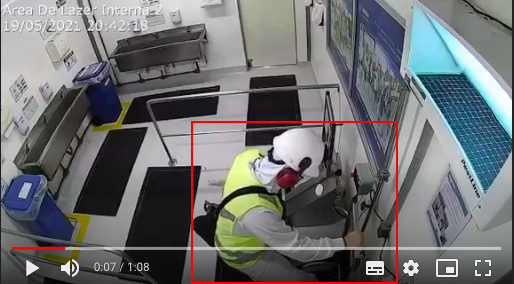

# Pré-processamento

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle
from IPython.display import clear_output
from sklearn.decomposition import PCA
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np 
import torch
import cv2

%matplotlib inline

# Absolute path to the video in drive
VIDEO_PATH = '/content/drive/MyDrive/AI Segurança - Vídeo/Videos Base/Video-AI_Seguranca.mp4'
# Absolute path to the dataset training in drive
CSV_PATH = '/content/drive/MyDrive/AI Segurança - Vídeo/Videos Base/dataset_eagle.csv'

## Usando a YoloV5 para detecção de pessoas 

Documentação: https://github.com/ultralytics/yolov5/issues/36

In [ ]:
def bgr_to_color_scheme(image: np.array, color_scheme: str):
  '''
  Coverts a image to a chosen color scheme
  '''
  if color_scheme == 'BGR':
    return image
  elif color_scheme == 'RGB':
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ## TODO: In later implementation use logger information
  print("Unrecognized color scheme, returning image as BGR")
  return image

def read_video_by_path(path: str, color_scheme: str = 'RGB'):
  '''
  Giving a path, reads video with OpenCV and yields each frame

  Args:
    path: The path to the video
    color_scheme: The frame color scheme

  Yields:
    A numpy array (uint8) representing the video frame in the chosen color scheme
  '''
  capture = cv2.VideoCapture(path)
  i_frame = 0
  while capture.isOpened():
    retval, frame = capture.read()
    if retval:
      i_frame += 1
      yield i_frame, bgr_to_color_scheme(frame, color_scheme)
    else:
      break

def detectPersons(i_demo_frame: int = 130):
  # Empty dataframe with the model prediction information
  df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name', 'frame'])
  for i_frame, frame in tqdm(read_video_by_path(path=VIDEO_PATH)):
    with torch.no_grad():
      # Model prediction for images with size 320x320
      pred = YoloModel(frame, size=320)
      # Getting the output as a pandas dataframe
      d = pred.pandas().xyxy[0]
      if not d.empty:
        # Adding the frame information to the generated dataframe
        d['frame'] = i_frame
        if i_frame == i_demo_frame:
          demo_frame = frame
        df = df.append(d)
  clear_output(wait=True)
  return df[df['name'] == 'person'], demo_frame

YoloModel = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
YoloModel.eval()
clear_output(wait=True)
Detections, demo_frame = detectPersons(130)
Detections

,xmin,ymin,xmax,ymax,confidence,class,name,frame
1,128.362503,215.799988,246.149994,319.299988,0.252441,0,person,75
1,128.474991,215.799988,246.375000,319.299988,0.256104,0,person,76
0,157.949997,185.649994,394.649994,319.750000,0.707520,0,person,83
0,157.724991,185.199982,394.875000,319.750000,0.719238,0,person,84
0,160.312500,177.099991,391.049988,318.399994,0.630859,0,person,85
...,...,...,...,...,...,...,...,...
0,285.074982,0.193750,330.074982,84.568748,0.487549,0,person,2028
0,285.074982,0.250000,330.074982,84.625000,0.482422,0,person,2029
0,285.074982,0.334375,330.074982,84.849998,0.529297,0,person,2030
0,285.074982,0.000000,332.324982,83.387497,0.381592,0,person,2031


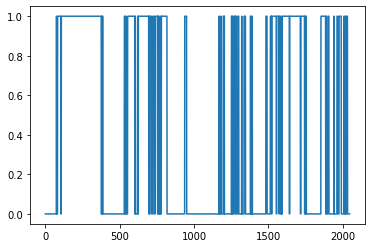

In [ ]:
%matplotlib inline
def plotDetections(dataframe: any) -> None:
  f = np.zeros(2048)
  f[dataframe['frame'].values.astype('int')] = 1
  plt.plot(f)
  plt.show()
  
plotDetections(Detections)

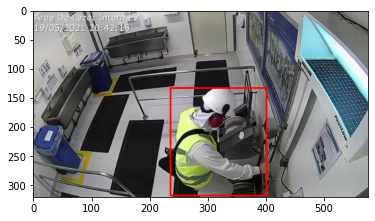

In [ ]:
def plotDemo(df: any, frame: any, i_frame: int = 130) -> None:
  df_demo = df[df['frame'] == i_frame]
  left = df_demo['xmin']
  top = df_demo['ymax']
  right = df_demo['xmax']
  bottom = df_demo['ymin']
  cv2.rectangle(frame, (left, top), (right, bottom), (255,0,0), 2)
  plt.imshow(frame)

plotDemo(Detections, demo_frame, 130)

## Construindo classificador de ações

In [ ]:
ResnetModel = models.resnet18(pretrained=True)
clear_output(wait=True)
EagleDataset = pd.read_csv(CSV_PATH)
EagleDataset

,Frame,Feet Cleaning,Hand Washing
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0
...,...,...,...
2043,2044,0,0
2044,2045,0,0
2045,2046,0,0
2046,2047,0,0


In [ ]:
# An object to define the tipes of objects worker will be interacting with.
class ActionObject:
  def __init__(self,actionType: str, bbox: tuple) -> None:
    self.bbox: tuple = bbox
    self.actionType: str = actionType
    self.beingUsed: int = -1
    print("Object",actionType,"created")
    if len(bbox) != 4:
      rint("\tWARNING: bbox has a shape different from 4. This will cause problems")
  def setUser(userid: int) -> bool:
    if(self.beingUsed != -1):
      print("\tWARNING:",actionType,"already being used. Acess by",userid)
    else:
      self.beingUsed = userid

# Creates the object "clean_feet" with this bbox.   
FeetCleaner = ActionObject("clean_feet",(250, 150, 170, 200))

Object clean_feet created


In [ ]:
resnet_transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize([256, 256]),
      transforms.ToTensor(),
      transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
      )
])

frames_index = np.arange(2048) + 1
labels = df_actions['Feet Cleaning'] == 1
MAX_INDEX = 1500
frames_index = frames_index[:MAX_INDEX]
labels = labels[:MAX_INDEX]
X_train_index, X_test_index, y_train, y_test = train_test_split(frames_index, labels, test_size=0.2)
# Getting only the feature extractor from the resnet model
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1])) 
feature_extractor.eval()
clear_output(wait=True)
print("Features extracted")

NameError: ignored

In [ ]:
def crop_region(img: np.array, crop_bbox: tuple):
  x, y, w, h = crop_bbox
  return img[y:y+h,x:x+w]

def extract_features_from_frame(frame: np.array, feature_extractor=feature_extractor):
  # Extract features using the feature extractor network
  frame = crop_region(frame,FeetCleaner.bbox)
  frame = resnet_transform(frame)
  return feature_extractor(frame.unsqueeze(dim=0)).squeeze()

frame_features = []
for i_frame, frame in tqdm(read_video_by_path(VIDEO_PATH)):
  frame_features.append(extract_features_from_frame(frame).detach().numpy())

X_train = frame_features[X_train_index]
X_test = frame_features[X_test_index]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
svc = SVC(C=.1)
svc.fit(X_train_norm, y_train)
svc.score(X_test_norm, y_test)



0it [00:00, ?it/s]

1it [00:00,  9.60it/s]

2it [00:00,  9.66it/s]

4it [00:00,  9.91it/s]

5it [00:00,  9.76it/s]

6it [00:00,  9.80it/s]

7it [00:00,  9.47it/s]

9it [00:00, 10.05it/s]

11it [00:01, 10.33it/s]

13it [00:01, 10.78it/s]

15it [00:01, 11.01it/s]

17it [00:01, 11.23it/s]

19it [00:01, 11.28it/s]

21it [00:01, 11.39it/s]

23it [00:02, 11.08it/s]

25it [00:02, 11.24it/s]

27it [00:02, 11.16it/s]

29it [00:02, 11.28it/s]

31it [00:02, 11.38it/s]

33it [00:02, 11.24it/s]

35it [00:03, 11.48it/s]

37it [00:03, 11.44it/s]

39it [00:03, 11.28it/s]

41it [00:03, 11.41it/s]

43it [00:03, 11.53it/s]

45it [00:04, 11.46it/s]

47it [00:04, 11.51it/s]

49it [00:04, 11.48it/s]

51it [00:04, 11.09it/s]

53it [00:04, 11.14it/s]

55it [00:04, 11.14it/s]

57it [00:05, 10.95it/s]

59it [00:05, 10.99it/s]

61it [00:05, 11.33it/s]

63it [00:05, 11.62it/s]

65it [00:05, 11.67it/s]

67it [00:05, 11.46it/s]

69it [00:06, 11.62it/s]

71it [00:06, 11.64it/s]

73it [00:06, 11.68it/s]

75it [00:0

TypeError: ignored

In [ ]:
# Check if someone is cleaning its foot on the frame
def is_cleaning_foot(frame, predictor=svc):
  feature = extract_features_from_frame(frame)
  retu = svc.predict(feature.detach().reshape(1, -1))
  print(retu, len(retu))
  return retu

In [ ]:
predictions = []
for i_frame, frame in tqdm(read_video_by_path(VIDEO_PATH)):
  predictions.append(is_cleaning_foot(frame))


0it [00:00, ?it/s]
2it [00:00, 11.07it/s]

[False] 1
[False] 1
[False] 1



4it [00:00, 11.28it/s]
6it [00:00, 11.61it/s]

[False] 1
[False] 1
[False] 1



8it [00:00, 11.86it/s]

[False] 1
[False] 1
[False] 1



10it [00:00, 11.77it/s]
11it [00:00, 10.92it/s]

[False] 1
[False] 1



13it [00:01, 10.90it/s]

[False] 1
[False] 1
[False] 1



15it [00:01, 10.92it/s]
17it [00:01, 10.97it/s]

[False] 1
[False] 1
[False] 1



19it [00:01, 11.05it/s]

[False] 1
[False] 1
[False] 1



21it [00:01, 10.97it/s]
23it [00:02, 11.06it/s]

[False] 1
[False] 1
[False] 1



25it [00:02, 11.31it/s]

[False] 1
[False] 1
[False] 1



27it [00:02, 11.22it/s]


[False] 1


KeyboardInterrupt: ignored

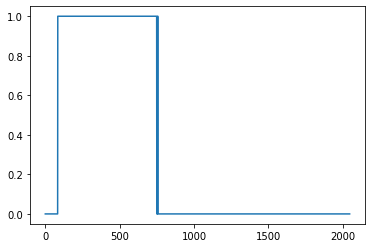

In [ ]:
plt.plot(predictions)

In [ ]:
# A "JSON" style object of all the actions required.
necessary_actions:dict = {
	# "clean_hands": {
	# 	"averageTimeFrames": 250,
	# 	"allowedTimeRange": 100
	# },
	"clean_feet": {
		"averageTimeFrames": 600,
		"allowedTimeRange": 200
	}
}

# Maximum time in frames that we consider its just the model not detecting, instead of the worker doing anything else.
MaximumDetectionGapTime: int = 300

In [ ]:
# A class that defines the worker
class Worker:
	# Creates worker, currently, uses the frame he is first detected ("enter_frame") as an unique id. Also has a list called boundaries that is the BBOX as [left, bottom, right, top]
	def __init__(self,current_frame: int, boundaries: list) -> None:
		self.actions: dict = {}
		self.enter_frame: int = current_frame
		self.boundaries: list = boundaries
		print("Worker",self.enter_frame,"entered")
		if len(boundaries) != 4:
			print("\tWARNING: boundaries has a shape different from 4. This will cause problems")
	def updateAction(self, frame: int, action: str) -> None:
		# Checks if this is persistance (he already started the action before) or if this is the first time
		if action in self.actions:
			print("Worker",self.enter_frame,"continues",action)
			if self.actions[action]["lastDetectedFrame"] > frame + MaximumDetectionGapTime:
				print("\tWARNING: more than 5 seconds since last detection")
			self.actions[action]["lastDetectedFrame"] = frame
			self.actions[action]["timeFrame"] += 1
		else:
			print("Worker",self.enter_frame,"started",action)
			self.actions[action] = {
				"startFrame": frame,
				"lastDetectedFrame": frame,
				"timeFrame": 1
			}
	def interact(self,frame: int,target: any) -> None:
		self.updateAction(frame,target.actionType)
		target.interact(self.enter_frame)
	def exit(self) -> bool:
    # TODO: Make the check of all actions
		completed_all_actions = True
		if completed_all_actions:
			print("Worker exited sucessfuly")
			return 1
		else:
			print("Worker left without all actions")
			return 0

## Vendo a projeção PCA do espaço de features:

In [ ]:
pca = PCA(2)

In [ ]:
pca.fit(X_train_norm)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_X = pca.transform(X_train_norm)

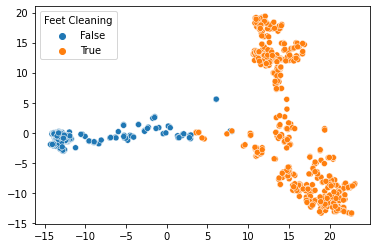

In [ ]:
sns.scatterplot(x=pca_X[:, 0], y=pca_X[:, 1], hue=y_train)